# Basic First Order Generating Function

In this example we demonstrate a basic application of the ``FirstOrderGeneratingFunctionClass``. We'll use the class to convert between "mean" and "osculating" elements when computing the secular evolution of a pair of planets near (but not in) a mean motion resonance.

In [1]:
import numpy as np
import rebound as rb
import sympy as sp
from matplotlib import pyplot as plt
from celmech import Poincare, PoincareHamiltonian
from celmech.lie_transformations import FirstOrderGeneratingFunction

from celmech.nbody_simulation_utilities import get_canonical_heliocentric_orbits

We begin by initializing a pair of planets with modest eccentricities %3 wide of the 3:2 MMR.

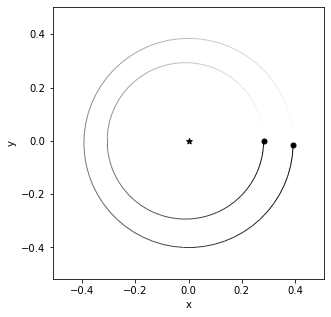

In [2]:
def get_sim():
    sim = rb.Simulation()
    sim.add(m=1)
    sim.add(m=1e-5,P = 1, e=0.04)
    sim.add(m=1e-5,P = (3/2) * ( 1 + .03), e=0.02,pomega = np.pi/2,l=0)
    sim.move_to_com()
    return sim
sim = get_sim()
rb.OrbitPlot(sim);


We'll make a ``PoincareHamiltonian`` model to study the secular evolution of the system, adding the leading order secular terms. 

In [3]:
pvars = Poincare.from_Simulation(sim)
pham = PoincareHamiltonian(pvars)
pham.add_secular_terms(inclinations=False)
pham.df

<IPython.core.display.Math object>

<!-- We expect this simple Hamiltonian will capture the features of the dynamics we're interested. -->
Of course, the true Hamiltonian includes an infinite number of additional disturbing function terms.
Lets write the total Hamiltonian as $$H=H_\mathrm{Kep} + \epsilon H_\mathrm{sec} + \epsilon H_\mathrm{fast}$$ where 
$$
\epsilon H_\mathrm{fast} = -\frac{Gm_1m_2}{a_2}\sum_{(k_1,k_2)\ne(0,0)}\sum_{\pmb{\nu}}\tilde{C}^{\pmb{\nu}}_\mathbf{k}(\alpha)e_1^{|k_3|+2\nu_3}e_2^{|k_4|+2\nu_4}\cos(k_1\lambda_2 + k_2\lambda_1 + k_3\varpi_1+k_4\varpi_2)
$$
containts rapidly-oscillating terms that have been omitted from our simple model Hamiltonian.
(Since our planets are coplanar, we've omitted inclination-dependent terms from the sum.)
Then our model Hamiltonian, ``pham.H`` is equivalent to  $H_\mathrm{Kep} + \epsilon H_\mathrm{sec}$ (ignoring higher-order secular terms). 

The fact that essentially all the terms in $H_\mathrm{fast}$ are small and rapidly oscillating means their effects on planets' dynamics can mostly be ignored and ``pham.H`` should provide a good approximation to the true evolution of the system. 

We can test how well our model captures the system's dynamics comparing integration results:

In [4]:
from celmech.nbody_simulation_utilities import get_canonical_heliocentric_orbits
cm_particles = pvars.particles
rb_particles = sim.particles 

N = 100
Tfin = 200
times = np.linspace(0,Tfin,N)
e_rb,e_cm = np.zeros((2,2,N))
for i,t in enumerate(times):
    sim.integrate(t)
    pham.integrate(t)
    orbits = get_canonical_heliocentric_orbits(sim)
    for j,orbit in enumerate(orbits):
        e_rb[j,i] = orbit.e
        e_cm[j,i] = pham.particles[j+1].e

Text(0.5, 0, 'time')

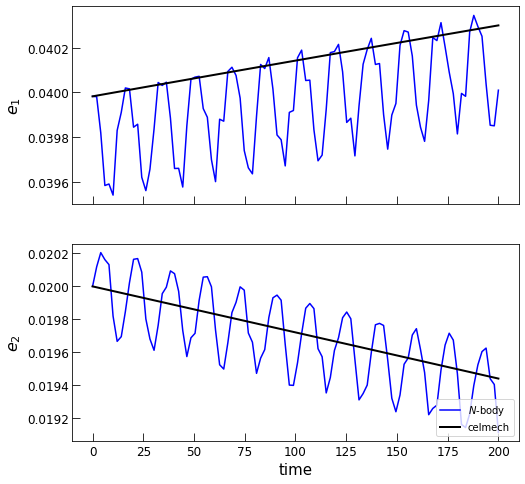

In [5]:
fig,ax = plt.subplots(2,1,figsize=(8,8),sharex=True)
for j in range(2):
    plt.sca(ax[j])
    plt.plot(times,e_rb[j],color='blue',label='$N$-body')
    plt.plot(times,e_cm[j],color='k',lw=2,label='celmech')
    plt.tick_params(labelsize=12,direction='in',size=8)
    plt.ylabel("$e_{}$".format(j+1),fontsize=16)
plt.legend(loc='lower right')
plt.xlabel("time",fontsize=15)

In the plot above we notice that our ``celmech`` model captures the long-term trend of the eccentricity evolution, but the $N$-body results show oscillations about mean eccentricities. The inner planet's eccentricity starts near the peak of one of these oscillations.

If we removed these oscillations, our secular model would provide a much better match to the $N$-body simulation.  We can remove the ocillating terms by introducing a near-identity [Lie transformation](https://celmech.readthedocs.io/en/latest/canonical_transformations.html#overview-of-canonical-perturbation-theory) that will make the correspondence between the full Hamiltonian and ``pham.H`` more precise. 

We'll create a generating function that eliminates the leading order terms associated with the 3:2 MMR,
$$
-\frac{Gm_1m_2}{a_2}
\left(
\tilde{C}^{(0,0,0,0)}_{(3,-2,-1,0,0,0)}(\alpha_{1,2})e_1\cos(3\lambda_2 - 2\lambda_1 -\varpi_1)
+
\tilde{C}^{(0,0,0,0)}_{(3,-2,0,-1,0,0)}(\alpha_{1,2})e_2\cos(3\lambda_2 - 2\lambda_1 -\varpi_2)
\right)~,
$$
from the Hamiltonian at first order since these low-order, near-resonant terms are responsible for most of the discrepancy between the $N$-body and ``celmech`` solutions. Then we want a function that satisfies
$$
[H_\mathrm{Kep},\chi]= \left(
n_1\frac{\partial}{\partial \lambda_1} 
+ 
n_2\frac{\partial}{\partial \lambda_2}
\right)\chi = \frac{Gm_1m_2}{a_2}
\left(
\tilde{C}^{(0,0,0,0)}_{(3,-2,-1,0,0,0)}(\alpha_{1,2})e_1\cos(3\lambda_2 - 2\lambda_1 -\varpi_1)
+
\tilde{C}^{(0,0,0,0)}_{(3,-2,0,-1,0,0)}(\alpha_{1,2})e_2\cos(3\lambda_2 - 2\lambda_1 -\varpi_2)
\right)
$$
It is straighforward to show that the desired function is
$$
\chi = -\left(
\frac{\tilde{C}^{(0,0,0,0)}_{(3,-2,-1,0,0,0)}(\alpha_{1,2})}{3n_2 - 2n_1}e_1\sin(3\lambda_2 - 2\lambda_1 -\varpi_1)
+
\frac{\tilde{C}^{(0,0,0,0)}_{(3,-2,0,-1,0,0)}(\alpha_{1,2})}{3n_2 - 2n_1}e_2\sin(3\lambda_2 - 2\lambda_1 -\varpi_2)
\right)
$$



# The ``FirstOrderGeneratingFunction`` class

We can use the ``FirstOrderGeneratingFunction`` class to automatically construct a Lie transformation that will eliminate user-specified terms from the Hamiltonian. 
First, let us make some new ``PoincareHamiltonian`` instances to illustrate how this works:

In [6]:
sim = get_sim()
pvars = Poincare.from_Simulation(sim)

# Used for illustration only
pham_Kep_only = PoincareHamiltonian(pvars)

# Used for illustration only
pham3to2_only = PoincareHamiltonian(pvars)
pham3to2_only.add_MMR_terms(3,1)

# Model to integrate
pham = PoincareHamiltonian(pvars)
pham.add_secular_terms(inclinations=False)

The Keplerian Hamiltonian, $H_0$:

In [7]:
H0 = pham_Kep_only.H
H0

   2   2   3    2   2   3
  G ⋅M₂ ⋅μ₂    G ⋅M₁ ⋅μ₁ 
- ────────── - ──────────
        2            2   
    2⋅Λ₂         2⋅Λ₁    

The perturbative 3:2 MMR Hamiltonian terms, $H_1$:

In [8]:
H1_3to2 = pham3to2_only.H - pham_Kep_only.H
H1_3to2

                                                               ⎛η₁⋅sin(2⋅λ₁ - 3⋅λ₂)   κ₁⋅cos(2⋅λ₁ - 3⋅λ₂)⎞     
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜─────────────────── + ───────────────────⎟   C_
                                                               ⎜   _______________       _______________ ⎟     
                                                               ⎝ ╲╱ \Lambda_{1,0}      ╲╱ \Lambda_{1,0}  ⎠     
- ──────────────────────────────────────────────────────────────────────────────────────────────────────── - ──
                                                  a_{2,0}                                                      

                                                           ⎛η₂⋅sin(2⋅λ₁ - 3⋅λ₂)   κ₂⋅cos(2⋅λ₁ - 3⋅λ₂)⎞
{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜─────────────────── + ───────────────────⎟
                                                           ⎜   _______________       _______________ ⎟
                  

The first-order Lie generating function that eliminates $H_1$:

In [9]:
pchi = FirstOrderGeneratingFunction(pvars)
pchi.add_MMR_terms(3,1)
pchi.chi

                                                               ⎛η₁⋅cos(2⋅λ₁ - 3⋅λ₂)   κ₁⋅sin(2⋅λ₁ - 3⋅λ₂)⎞     
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜─────────────────── - ───────────────────⎟   C_
                                                               ⎜   _______________       _______________ ⎟     
                                                               ⎝ ╲╱ \Lambda_{1,0}      ╲╱ \Lambda_{1,0}  ⎠     
- ──────────────────────────────────────────────────────────────────────────────────────────────────────── - ──
                                           ⎛   2   2   3      2   2   3⎞                                       
                                           ⎜3⋅G ⋅M₂ ⋅μ₂    2⋅G ⋅M₁ ⋅μ₁ ⎟                                       
                                   a_{2,0}⋅⎜──────────── - ────────────⎟                                       
                                           ⎜      3              3     ⎟                                

Application of the generating function eliminates the 3:2 terms, i.e., $[H_0,\chi]+H_1 = 0$. 

In [10]:
sp.simplify(pchi.Lie_deriv(H0) + H1_3to2).expand()

0

# Applying osculating-to-mean transformation to an integration

Now we'll use our generating function, ``pchi`` to transform back and forth between osculating canonical variables (i.e., those that include the effect of the oscillating 3:2 terms) and mean canonical variables (the canonical variables for which oscillating 3:2 terms have been elminated.)

The variables inhereted from the rebound simulation represent osculating variables, so we start by correcting them with ``pchi.osculating_to_mean()``

In [11]:
pchi.osculating_to_mean()

cm_particles = pvars.particles
rb_particles = sim.particles 
Tsup= np.abs(2 * np.pi / (3 * cm_particles[2].n - 2 * cm_particles[1].n))

In the integration loop below, we'll do our integration in mean variables and use ``pchi`` to go back and forth between osculating and mean variables. 
We see in the plot that the 3:2 MMR terms that we've now eliminated were repsonsible for the majority of the difference between N-body and ``celmech``.

Text(0.5, 0, 'time')

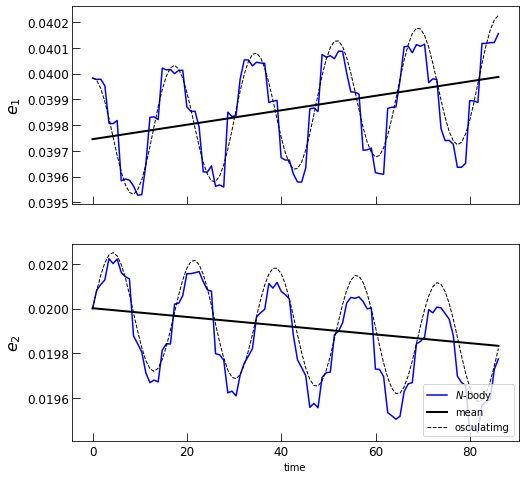

In [12]:
N = 100
times = np.linspace(0,5,N)*Tsup
eN,emean,eosc = np.zeros((3,2,N))
for i,t in enumerate(times):
    sim.integrate(t)
    pham.integrate(t)
    orbits = get_canonical_heliocentric_orbits(sim)
    for j,orbit in enumerate(orbits):
        eN[j,i] = orbit.e
        emean[j,i] = pham.particles[j+1].e
        
    # get osculating variables
    pchi.mean_to_osculating()
    for j in range(2):
        eosc[j,i] = pham.particles[j+1].e
    # return to mean variables
    pchi.osculating_to_mean()

fig,ax = plt.subplots(2,1,figsize=(8,8),sharex=True)
for j in range(2):
    plt.sca(ax[j])
    plt.plot(times,eN[j],color='blue',label='$N$-body')
    plt.plot(times,emean[j],color='k',lw=2,label='mean')
    plt.plot(times,eosc[j],color='k',lw=1,ls='--',label='osculatimg')
    plt.tick_params(labelsize=12,direction='in',size=8)
    plt.ylabel("$e_{}$".format(j+1),fontsize=16)
plt.legend(loc='lower right')
plt.xlabel("time")